In [ ]:
from pycaret.classification import *
from pycaret.utils import enable_colab
enable_colab()

import numpy as np
import pandas as pd
import tensorflow as tf
import os 
import random
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,8)

def seed_all(s):
    random.seed(s)
    np.random.seed(s)
    tf.random.set_seed(s)
    os.environ['PYTHONHASHSEED'] = str(s)
    
global_seed = 0
seed_all(global_seed)

In [ ]:
dataset_file = '/content/drive/MyDrive/Americanas/dataset_cdjr.parquet.gzip'

In [39]:
df = pd.read_parquet(dataset_file)

TargetVariable=['target']
Features=['feature0','feature1','feature2','feature3','feature4','feature5','feature6','feature7',
         'feature8','feature9','feature10','feature11','feature12','feature13','feature14','feature15']

df.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,target
337,200.0,2,662.28,39.10,-188.55,0.246978,761,0.004548,3.523703,167326,33441.06,0.019804,26.850,0.009198,94.611429,7,0
266,150.0,2,0.00,149.55,-0.45,0.150000,3,0.037975,0.000000,79,78.93,0.000000,0.000,0.000000,0.000000,0,1
236,50.0,1,346.08,30.41,-102.10,2.430952,42,0.004239,3.389618,9907,18858.77,0.018351,25.525,0.095238,86.520000,4,0
274,100.0,2,0.00,43.84,-56.16,0.150968,372,0.005854,0.000000,63544,1164.11,0.000000,0.000,0.000000,0.000000,0,1
208,50.0,1,87.56,-3.05,-94.50,0.412664,229,0.004572,0.926561,50089,1786.26,0.049019,94.500,0.004367,87.560000,1,0


# Transformação dos dados

Através da biblioteca Pycaret aplicaremos o seguinte pré-processamento dos dados:
- Normalização (zscore);
- Transformação (quantile).

In [ ]:
experimento = setup(data=df,
                   target='target',
                   normalize=True,
                   transformation=True,
                   transformation_method='quantile',
                   log_experiment=False,
                   experiment_name='Desafio_Tecnico',
                   session_id=1,
                   silent=True)

In [41]:
df_transformed = pd.concat([get_config('X'),get_config('y')], axis=1)
 
X=df_transformed[Features].values
y=df_transformed[TargetVariable].values

df_transformed.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,target
337,0.150969,0.026998,0.502402,0.450559,-0.065605,-0.309524,0.342057,-0.166590,0.841621,0.366695,1.447731,-0.166590,0.205831,0.629181,0.391558,0.587418,0
266,-0.019283,0.026998,-5.199337,1.364826,2.503199,-5.199337,-2.356229,1.787566,-5.199337,-2.503197,-1.517142,-5.199337,-5.199337,-5.199337,-5.199337,-5.199337,1
236,-0.701362,-0.551139,0.293381,0.245391,0.261319,2.503199,-1.230629,-0.293381,0.809093,-0.897915,1.272834,-0.174416,0.174416,2.739470,0.261319,0.412463,0
274,-0.265312,0.026998,-5.199337,0.537722,0.493671,-0.886432,-0.104310,0.158775,-5.199337,-0.135385,-0.088813,-5.199337,-5.199337,-5.199337,-5.199337,-5.199337,1
208,-0.701362,-0.551139,-0.167469,-1.053073,0.331174,0.335339,-0.426299,-0.156769,0.033365,-0.264987,0.096982,-0.069958,1.035735,0.177856,0.267383,-0.115950,0


# Seleção de Features

Dado a ocorrência de features correlatas, considerei pertinente aplicar uma seleção de feature buscando evitar redundância de informação para o modelo. Outro ponto é buscar eliminar features ruidosas.
  
Inicialmente, analisei a importância das features para o algoritmo Random Forest:

Random Forest - Feature Importance:

      Variable  coefficients
10  feature10      0.114204
7    feature7      0.111741
3    feature3      0.087616
5    feature5      0.083398
4    feature4      0.076316
9    feature9      0.075890
6    feature6      0.071359
11  feature11      0.061185
2    feature2      0.047973
0    feature0      0.044892
13  feature13      0.043568
15  feature15      0.039647
14  feature14      0.037620
12  feature12      0.035538
8    feature8      0.035424
1    feature1      0.033630 



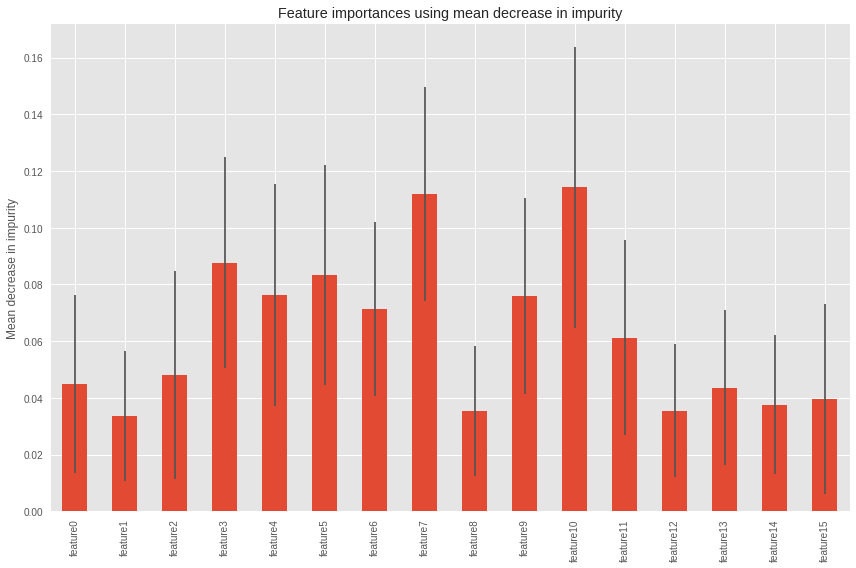

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300,random_state=0)
rf = rf.fit(X, y.ravel())

coefficients = abs(rf.feature_importances_.reshape(len(Features), 1))
listist = pd.concat((pd.DataFrame(Features, columns = ['Variable']), pd.DataFrame(coefficients, columns = ['coefficients'])), axis = 1).sort_values(by='coefficients', ascending = False)
print('Random Forest - Feature Importance:')
print('\n',listist,'\n')

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(rf.feature_importances_, index=Features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using mean decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [43]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(rf).fit(X, y.ravel())
print(f'Threshold: {selector.threshold_}')
for x in zip(Features,selector.estimator_.feature_importances_,selector.get_support()):
    print(f'{x[0]} - importance:{abs(x[1])} - selected:{x[2]}')

Threshold: 0.0625
feature0 - importance:0.04489212102620214 - selected:False
feature1 - importance:0.03362953001960971 - selected:False
feature2 - importance:0.04797256136698696 - selected:False
feature3 - importance:0.08761610509088477 - selected:True
feature4 - importance:0.07631617222945204 - selected:True
feature5 - importance:0.083397918620574 - selected:True
feature6 - importance:0.07135853738058835 - selected:True
feature7 - importance:0.11174109340609759 - selected:True
feature8 - importance:0.03542353679663671 - selected:False
feature9 - importance:0.0758903825710648 - selected:True
feature10 - importance:0.11420440785974734 - selected:True
feature11 - importance:0.06118456813725776 - selected:False
feature12 - importance:0.0355379621499697 - selected:False
feature13 - importance:0.04356776578407385 - selected:False
feature14 - importance:0.03762021095499827 - selected:False
feature15 - importance:0.03964712660585601 - selected:False


Aqui temos um problema. Feature importance usando mean decrease in impurity para algoritmos baseados em árvores possue a tendência em favorecer features com grande proporção de valores distintos. Como vimos na análise exploratória, temos algumas features com essa característica. Assim, optei por adicionar seleção de feature de acordo com outros algoritmos. A escolha desses algoritmos se deu na tentativa de experimentar diferentes abordagens:
- Algoritmo baseado em árvores: Random Forest;
- Support vectors: SVM;
- Gradiente: SGD;
- Modelo linear: Ridge.

In [44]:
from sklearn import svm
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import RepeatedKFold

svm = svm.SVC().fit(X, y.ravel())
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
perm_importance = PermutationImportance(svm, cv=cv)
selector = SelectFromModel(perm_importance).fit(X, y.ravel())

print(f'Threshold: {selector.threshold_}')
for x in zip(Features,selector.estimator_.feature_importances_,selector.get_support()):
    print(f'{x[0]} - importance:{abs(x[1])} - selected:{x[2]}')

Threshold: 0.0018143254785327493
feature0 - importance:0.006204529855868219 - selected:True
feature1 - importance:0.003690993670403412 - selected:False
feature2 - importance:0.008894989704873017 - selected:True
feature3 - importance:0.009709448638755436 - selected:False
feature4 - importance:0.0017509341874475674 - selected:False
feature5 - importance:0.004622893311980471 - selected:True
feature6 - importance:0.0008114085258903388 - selected:False
feature7 - importance:0.001876000915122386 - selected:True
feature8 - importance:0.0002760619232822433 - selected:False
feature9 - importance:0.00787310302752993 - selected:False
feature10 - importance:0.004150080073209788 - selected:True
feature11 - importance:0.0005582246625486158 - selected:False
feature12 - importance:0.0009959582094105101 - selected:False
feature13 - importance:0.014315564706779521 - selected:True
feature14 - importance:0.00019675131548844296 - selected:False
feature15 - importance:0.010932662243575067 - selected:True


In [45]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier().fit(X, y.ravel())
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
perm_importance = PermutationImportance(sgd, cv=cv)
selector = SelectFromModel(perm_importance).fit(X, y.ravel())

print(f'Threshold: {selector.threshold_}')
for x in zip(Features,selector.estimator_.feature_importances_,selector.get_support()):
    print(f'{x[0]} - importance:{abs(x[1])} - selected:{x[2]}')

Threshold: 0.012952794936322724
feature0 - importance:0.006887821246091675 - selected:False
feature1 - importance:0.004574086784107366 - selected:False
feature2 - importance:0.005420575001906504 - selected:False
feature3 - importance:0.008007320979180964 - selected:False
feature4 - importance:0.04877144818119421 - selected:True
feature5 - importance:0.011705940669564555 - selected:False
feature6 - importance:0.0017265309235110137 - selected:False
feature7 - importance:0.026244185159765104 - selected:True
feature8 - importance:0.03039274002897887 - selected:True
feature9 - importance:0.004026538549531003 - selected:False
feature10 - importance:0.03501868374895141 - selected:True
feature11 - importance:0.002800274536719282 - selected:False
feature12 - importance:0.022238999466178598 - selected:True
feature13 - importance:0.0015648592999313693 - selected:False
feature14 - importance:0.007825821703652853 - selected:False
feature15 - importance:0.014997330893006927 - selected:True


In [46]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X, y.ravel())
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
perm_importance = PermutationImportance(ridge, cv=cv)
selector = SelectFromModel(perm_importance).fit(X, y.ravel())

print(f'Threshold: {selector.threshold_}')
for x in zip(Features,selector.estimator_.feature_importances_,selector.get_support()):
    print(f'{x[0]} - importance:{abs(x[1])} - selected:{x[2]}')

Threshold: 0.12291768117793653
feature0 - importance:0.07621139134411671 - selected:False
feature1 - importance:0.07177906024658351 - selected:False
feature2 - importance:0.5365751704189398 - selected:True
feature3 - importance:0.006716533192180611 - selected:False
feature4 - importance:0.3107920808181944 - selected:True
feature5 - importance:0.03704048071393698 - selected:False
feature6 - importance:0.12787805688076695 - selected:True
feature7 - importance:0.15537339002970046 - selected:True
feature8 - importance:0.07100230391904445 - selected:False
feature9 - importance:0.01032236269765485 - selected:False
feature10 - importance:0.03648808982094869 - selected:False
feature11 - importance:0.022070020132146234 - selected:False
feature12 - importance:0.03541618082839346 - selected:False
feature13 - importance:0.0500408043805295 - selected:False
feature14 - importance:0.12401482338346803 - selected:True
feature15 - importance:0.29496215004037996 - selected:True


Assim, chegamos em 4 grupos de features selecionadas:
- Conjunto de features selecionadas a partir da feature importance do algoritmo Random Forest;
  - feature3, feature4, feature5, feature6, feature7, feature9, feature10
- Conjunto de features selecionadas a partir da feature importance do algoritmo SVM;
  - feature0, feature2, feature5, feature7, feature10, feature13, feature15
- Conjunto de features selecionadas a partir da feature importance do algoritmo SGD;
  - feature4, feature7, feature8, feature10, feature12, feature15
- Conjunto de features selecionadas a partir da feature importance do algoritmo Ridge.
  - feature2, feature4, feature6, feature7, feature14, feature15